In [154]:
import pandas as pd
from database.database import Database
from modeler.modeler import Modeler as m
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
import pickle

In [2]:
project_name = "dopa"

In [3]:
db = Database(project_name)

In [129]:
## Transform data
ch = pd.read_csv("Challenger_Ranked_Games.csv")
ch["category"] = "ch"
gm = pd.read_csv("GrandMaster_Ranked_Games.csv")
gm["category"] = "gm"
mast = pd.read_csv("Master_Ranked_Games.csv")
mast["category"] = "m"

In [130]:
data = pd.concat([ch,gm,mast])

In [131]:
data.columns

Index(['gameId', 'gameDuraton', 'blueWins', 'blueFirstBlood', 'blueFirstTower',
       'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor',
       'blueDragonKills', 'blueBaronKills', 'blueTowerKills',
       'blueInhibitorKills', 'blueWardPlaced', 'blueWardkills', 'blueKills',
       'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
       'blueTotalMinionKills', 'blueTotalLevel', 'blueAvgLevel',
       'blueJungleMinionKills', 'blueKillingSpree', 'blueTotalHeal',
       'blueObjectDamageDealt', 'redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt', 'cate

In [132]:
for column in data.columns:
    if "First" in column:
        data[column] = [True if x == 1 else False for x in data[column]]

In [133]:
data["redGoldDiff"] = data["redTotalGold"] - data["blueTotalGold"]
data["blueGoldDiff"] = -data["redGoldDiff"]

In [134]:
red_cols = [x for x in data.columns if "red" in x ]
blue_cols = [x for x in data.columns if "blue" in x ]
red_cols.append("category")
blue_cols.append("category")
red = data[red_cols]
red["side"] = 0
red.rename(columns={"redWins":"wins"},inplace=True)
blue = data[blue_cols]
blue["side"] = 1
blue.rename(columns={"blueWins":"wins"},inplace=True)
for dataset in [red,blue]:
    for col in dataset.columns:
        dataset.rename(columns={col:col.replace("red","").replace("blue","")},inplace=True)
data = pd.concat([red,blue])

In [147]:
factors = [x for x in data.columns if "First" in x]
# factors.append("GoldDiff")

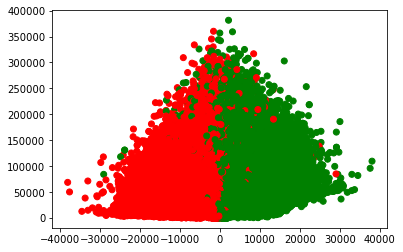

In [148]:
data["color"] = ["green" if x == 1 else "red" for x in data["wins"]]
plt.scatter(data["GoldDiff"],data["ChampionDamageDealt"],color=data["color"])

In [149]:
## Refine Data
## if classification make appropriate changes
label = "wins"
data["y"] = data[label]
data.drop(label,axis=1)
data = data.sample(frac=1)
models = []
for side in data["side"].unique():
    for tier in data["category"].unique():
        try:
            tier_data = data[(data["category"]==tier) & (data["side"]==side)]
            train = tier_data.iloc[:int(tier_data.index.size * 0.7)]
            test = tier_data.iloc[int(tier_data.index.size * 0.7):]
            X = train[factors]
            y = train[["y"]]
#             y["y_class"] = 1
            refined_data = {"X":X,"y":y}
            model = m.xgb_classify(refined_data,multioutput=False)
            model["tier"] = tier
            model["side"] = side
            predictions = model["model"].predict(test[factors])
            score = len([i for i in range(len(predictions)) if predictions[i] == test["y"].iloc[i]]) / len(predictions)
            model["actual_score"] = score
            models.append(model)
        except Exception as e:
            print(str(e))

In [159]:
## Model
ms = pd.DataFrame(models)

In [160]:
ms["model"] = [pickle.dumps(x) for x in ms["model"]]

In [161]:
db.connect()
db.store_data("models",ms)
db.close()

In [162]:
test[factors]

,FirstBlood,FirstTower,FirstBaron,FirstDragon,FirstInhibitor
1725,False,False,False,False,False
358,False,False,True,False,True
5289,True,True,False,False,True
17411,True,True,True,True,False
19061,True,True,True,False,True
...,...,...,...,...,...
2943,True,True,False,True,False
19224,False,False,False,False,False
15173,True,False,True,True,False
11834,True,False,False,False,False
